# Classifieur Random Forest
Le classifieur Random Forest est un modèle robuste et puissant, adapté à des ensembles de données complexes. Il offre une grande flexibilité et est capable de capturer des relations non linéaires entre les caractéristiques, ce qui en fait un choix intéressant pour notre problème de classification des espèces de feuilles

In [2]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()

(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 195 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur Random Forest, nous utilisons également trois hyperparamètres clés :

- Le nombre d'arbres dans la forêt (n_estimators).
- La profondeur maximale de chaque arbre (max_depth).
- Le nombre minimal d'échantillons requis pour diviser un nœud (min_samples_split).

Bien que le nombre d'arbres soit souvent l'hyperparamètre le plus crucial, nous explorons également l'impact des autres hyperparamètres sur les performances du modèle.

### Recherche des hyperparamètres

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

In [5]:
hyperparameters_rf = {
    'n_estimators': range(10, 101, 10),
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_rf, results_rf = DM.train_model(RandomForestClassifier(), hyperparameters_rf, dataset)
print('Best:', grid_rf.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


Best: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 90}


### Analyse de l'entrainement

Le nombre optimal d'estimateurs (n_estimators) est de 90, indiquant ainsi une configuration où le modèle Random Forest se base sur un ensemble significatif d'arbres de décision pour effectuer des prédictions sur les espèces de feuilles. On peut examiner les performances du modèle en considérant le score associé à ce nombre particulier d'estimateurs et évaluer l'influence des autres hyperparamètres sur ces résultats.

In [10]:
results_rf[results_rf.param_n_estimators == grid_rf.best_params_['n_estimators']]

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
8,90,None,2,0.966833,1
18,90,None,5,0.962517,4
28,90,None,10,0.942279,30
38,90,10,2,0.878803,54
48,90,10,5,0.878793,55
58,90,10,10,0.834021,70
68,90,20,2,0.961057,8
78,90,20,5,0.963935,2
88,90,20,10,0.936503,35


Pour la profondeur maximale des arbres, on constate que l'absence de limite de profondeur semble être préférable, car elle obtient le meilleur score (0.9668) par rapport aux autres valeurs de max_depth.

L'impact de la division minimale des échantillons (min_samples_split) sur les performances est également observé. Un nombre de 2 pour min_samples_split semble être plus performant que 5 et 10.

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour réellement voir l'impact de leur variation sur le score.

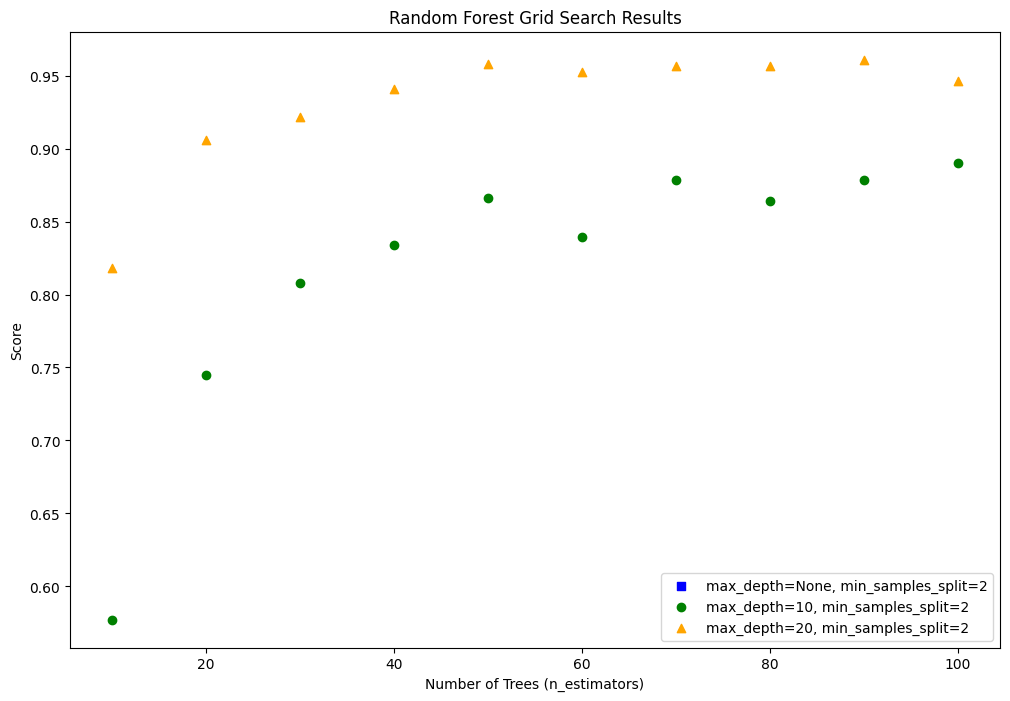

In [6]:
plt.figure(figsize=(12, 8))

# Exploration du nombre d'arbres (n_estimators)
plt.scatter(results_rf.query('param_max_depth == None and param_min_samples_split == 2')['param_n_estimators'],
            results_rf.query('param_max_depth == None and param_min_samples_split == 2')['mean_test_score'],
            marker='s', color='blue', label='max_depth=None, min_samples_split=2')
plt.scatter(results_rf.query('param_max_depth == 10 and param_min_samples_split == 2')['param_n_estimators'],
            results_rf.query('param_max_depth == 10 and param_min_samples_split == 2')['mean_test_score'],
            marker='o', color='green', label='max_depth=10, min_samples_split=2')
plt.scatter(results_rf.query('param_max_depth == 20 and param_min_samples_split == 2')['param_n_estimators'],
            results_rf.query('param_max_depth == 20 and param_min_samples_split == 2')['mean_test_score'],
            marker='^', color='orange', label='max_depth=20, min_samples_split=2')

# Ajouter d'autres combinaisons d'hyperparamètres au besoin...

plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Score")
plt.title("Random Forest Grid Search Results")
plt.legend()
plt.show()


On remarque la distance de manhattan est toujours meilleure que les distances euclidienne et cosinus, et la pondération des voisins selon la distance est toujours meilleure que la pondération uniforme.

De plus, le score commence à décroitre lorsque le nombre de voisins est supérieur à 4. C'est assez logique; notre ensemble d'entrainement contient très peu de données par classe donc si on regarde beaucoup de voisins, la majorité d'entre eux appartiendront à des classes différentes. La décroissance est encore plus grande sans pondération, justement parce qu'on accorde trop d'importance aux voisins éloignés qui sont dans des classes différentes.

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

### Averages ###
   - precision : 97.222% ± 7.897%
   - recall    : 96.296% ± 11.556%
   - f1_score  : 96.089% ± 8.349%
################


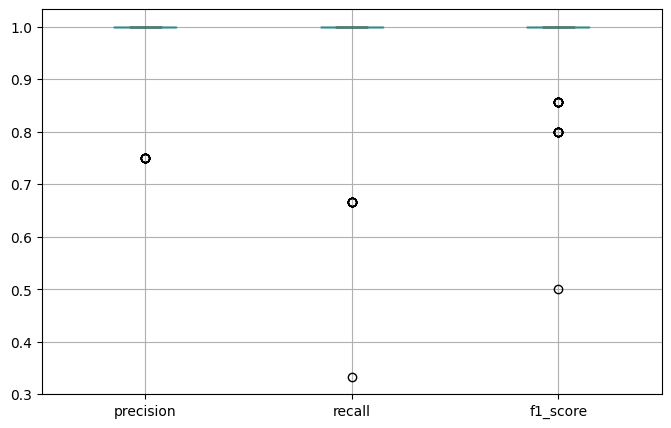

In [11]:
test_preds = grid_rf.predict(dataset.x_test)
test_reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Comme nous avons 99 classes, il n'est pas pratique de regarder les résultats pour chacune d'entre elles. On regarde plutôt la moyenne de chaque métrique sur l'ensemble des classes. On peut alors voir que notre modèle fonctionne très bien. Il est à la fois précis et juste.

Comme on peut le voir dans le boxplot, les prédictions sont parfaites (métriques à 1.0) pour la grande majorité des classes. Il y a cependant des classes pour lesquelles le modèle a moins bien performé. Regardons de quelles classes il s'agit.

In [12]:
bad_classes = test_reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                         precision    recall  f1_score
Arundinaria_Simonii           1.00  0.666667  0.800000
Betula_Pendula                0.75  1.000000  0.857143
Cornus_Chinensis              0.75  1.000000  0.857143
Cotinus_Coggygria             1.00  0.666667  0.800000
Eucalyptus_Glaucescens        0.75  1.000000  0.857143
Fagus_Sylvatica               0.75  1.000000  0.857143
Liriodendron_Tulipifera       1.00  0.666667  0.800000
Magnolia_Salicifolia          0.75  1.000000  0.857143
Quercus_Agrifolia             0.75  1.000000  0.857143
Quercus_Brantii               0.75  1.000000  0.857143
Quercus_Castaneifolia         1.00  0.666667  0.800000
Quercus_Crassifolia           0.75  1.000000  0.857143
Quercus_Palustris             0.75  1.000000  0.857143
Quercus_Phillyraeoides        1.00  0.666667  0.800000
Quercus_Pontica               1.00  0.666667  0.800000
Quercus_Pyrenaica             0.75  1.000000  0.857143
Quercus_Shumardii             1.00  0.666667  0.800000
Quercus_Va

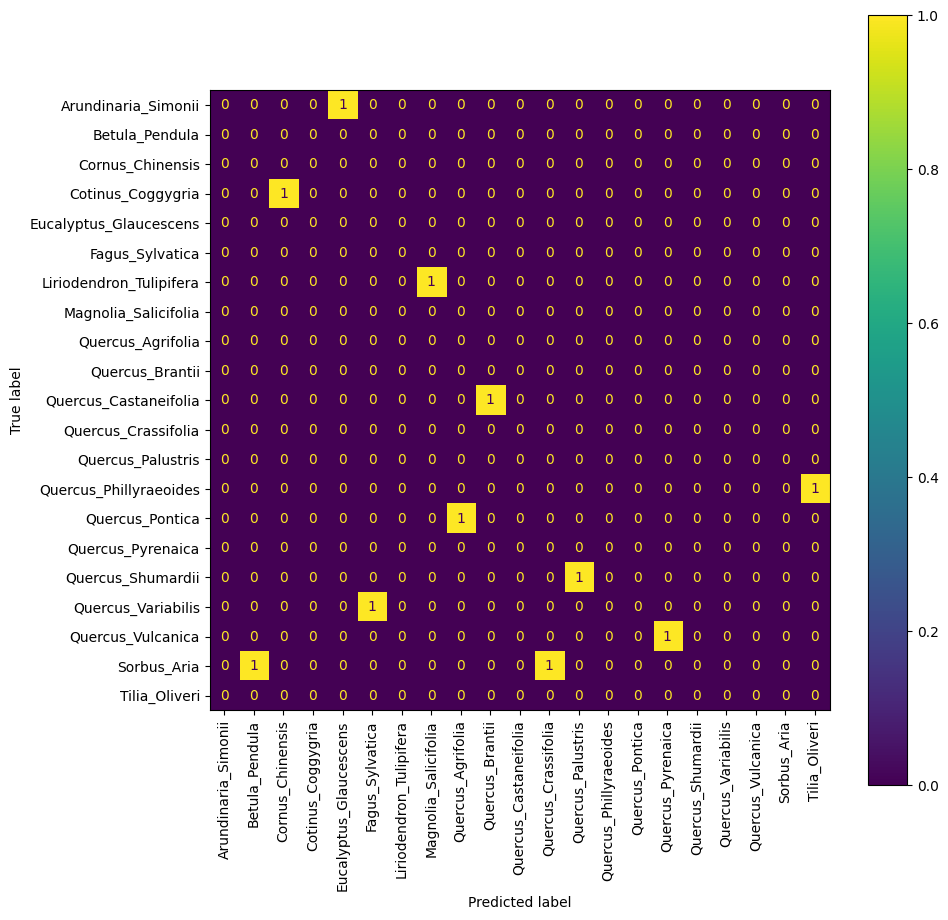

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(10)
display.figure_.set_figheight(10)

plt.show()

Il ne semble pas se dégager de relation particulière parmis les mauvaises prédictions. Il s'agit donc probablement de données pour lesquelles les caractéristiques sont moins distinctes.

### Conclusion

Le classifieur KNN est optimal lorsqu'on utilise 4 voisins, la distance de manhattan et une pondération des voisins selon la distance. Avec ces hyperparamètres, le modèle performe très bien (> 95% pour chaque métrique d'évaluation) et ne semble donc ni sous-apprendre ni sur-apprendre.

Cependant, on doit rappeler que notre jeu de données contient beaucoup de classes (99) et assez peu de données par classes (seulement 10). Notre ensemble de test lui ne contenait que 3 données par classe, ce qui est très peu. Donc il est difficile de dire si les résultats obtenus correspondent aux vraies performances du modèle.